In [1]:
from IPython.display import clear_output 
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
# from torchvision import models, transforms
# import sys
# import os
from PIL import Image
import torch
# import torch.functional as F
import numpy as np
clear_output()
# import glob
from utils import *
from datetime import date
from torch.optim import lr_scheduler
import torchvision
from constants import mean, std
from PapilledemaLoader import PapilledemaDataset, PapilSeverityDataset, OHTSDataset, OHTSSeverityDataset
import torch.nn as nn
import torch.optim as optim

In [100]:
data_dir = '/mnt/c/Users/PCM/Dropbox/OHTS'
image_datasets = {x: OHTSDataset(data_dir=data_dir, phase=x) for x in ['train', 'val', 'test']}
shuffle = {'train':True, 'val':False, 'test':False}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=shuffle[x], num_workers=1)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['glaucoma', 'normal']


# Plot binary contrastive

In [6]:
bestsimese50simclr = SiameseNetwork101().to(device)
state_dict = torch.load('./pretrained/OHTS-contrastive50-2024-03-12.pt')
bestsimese50simclr.load_state_dict(state_dict)
newmodel = bestsimese50simclr.cnn1#torch.nn.Sequential(*(list(bestsimese50simclr.cnn1.children())[:-1]))#bestsmodel.bestsimese50simclr.cnn1#

load simclr resnet


In [7]:
test_acc = 0
test_embeddings = torch.zeros((0, 256))
test_targets = []
count = 0
for inputs, labels in dataloaders['train']:
        newmodel.eval()
        inputs = inputs.to(device)
        labels = labels[0]
        count = count + 1
        if(count == 2000):
            break
        with torch.no_grad():
            output = newmodel(inputs)
            test_targets.append(labels)
            test_embeddings  = torch.cat((test_embeddings, output.detach().cpu().flatten().unsqueeze(0)), axis=0)

test_targets = torch.stack(test_targets).flatten()
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1999 samples in 0.001s...
[t-SNE] Computed neighbors for 1999 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1999
[t-SNE] Computed conditional probabilities for sample 1999 / 1999
[t-SNE] Mean sigma: 0.000039
[t-SNE] KL divergence after 250 iterations with early exaggeration: 297.631073
[t-SNE] KL divergence after 1000 iterations: 0.912810


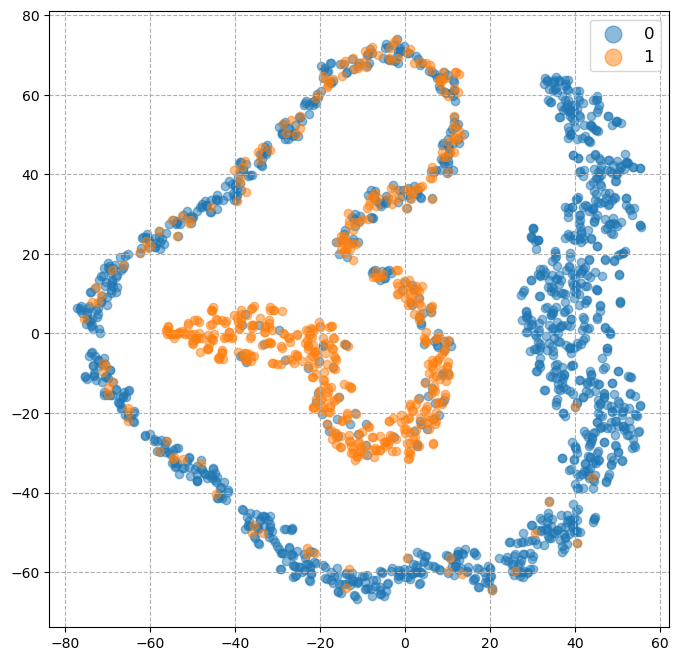

In [8]:
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

tsne = TSNE(2, verbose=1, n_iter=1000, init='random', perplexity=10, early_exaggeration=40, metric="cosine")
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 2
for lab in range(num_categories):
    indices = targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.grid(linestyle='--')
plt.show()

# Plot preference optimization

In [101]:
bestsmodel = SeverityModel().to(device)
state_dict = torch.load('./pretrained/OHTS-smodel50-wofreeze-2024-03-12.pt')
bestsmodel.load_state_dict(state_dict)
newmodel = bestsmodel.bestsimese50simclr.cnn1

load simclr resnet


In [102]:
# annotated_imgs_glaucoma = pd.read_csv("../Glaucoma-Ranking/datasets/annotated_imgs_glaucoma.csv")
import pandas as pd
ohts_merged_20200918 = pd.read_csv('../Glaucoma-Ranking/datasets/ohts_merged_20200918.csv', low_memory=False)
data_sortby_md = ohts_merged_20200918.loc[:,['filename', 'mdindex']].sort_values(by=['filename']).reset_index(drop=True)
data_sortby_md['filename'] = data_sortby_md.filename.str.replace('(tif)', 'jpg', regex=True)

In [129]:
test_acc = 0
test_embeddings = torch.zeros((0, 256))
test_targets = []
fname_list = []
count = 0
for i, (inputs, labels) in enumerate(dataloaders['test'], 0):
        newmodel.eval()
        inputs = inputs.to(device)
        labels = labels[0]
        count = count + 1
        if(count == 2000):
            break
        sample_fname = dataloaders['test'].dataset.samples[i][0].split('/')[-1]
        fname_list.append(sample_fname)
        # data_sortby_md[data_sortby_md['filename'].isin(fname)].fillna(0).mdindex.to_numpy()
        with torch.no_grad():
            output = newmodel(inputs)
            test_targets.append(labels)
            test_embeddings  = torch.cat((test_embeddings, output.detach().cpu().flatten().unsqueeze(0)), axis=0)

test_targets = torch.stack(test_targets).flatten()
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)

In [130]:
mdlist = data_sortby_md[data_sortby_md['filename'].isin(fname_list)].fillna(0).mdindex.to_numpy()
color = test_targets*mdlist

In [131]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
# normalized_color = NormalizeData([color[indices]])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1999 samples in 0.000s...
[t-SNE] Computed neighbors for 1999 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1999
[t-SNE] Computed conditional probabilities for sample 1999 / 1999
[t-SNE] Mean sigma: 0.000016


[t-SNE] KL divergence after 250 iterations with early exaggeration: 184.374146
[t-SNE] KL divergence after 1000 iterations: 0.743519


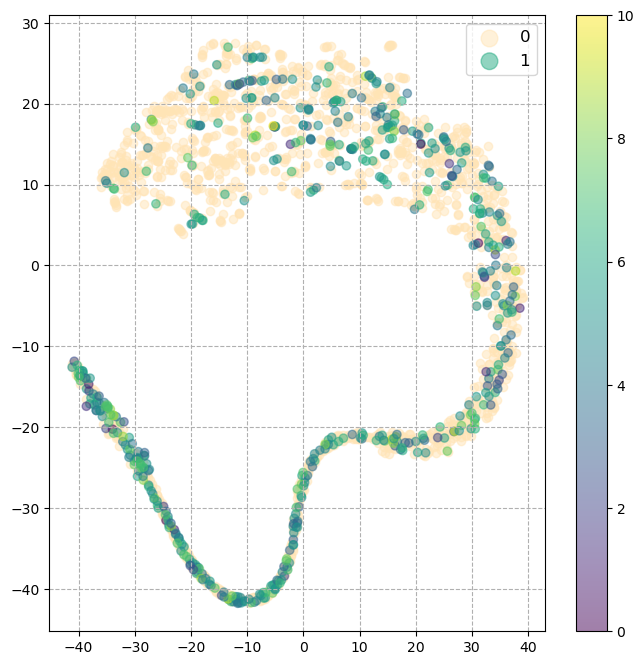

In [132]:
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

tsne = TSNE(2, verbose=1, n_iter=1000, init='random', perplexity=40, early_exaggeration=30, metric="cosine")
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 2
for lab in range(num_categories):
    indices = targets==lab
    if(lab == 0):
        ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab, alpha=0.5, c='moccasin')
    else:
        axs = ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5, c=NormalizeData([color[indices]])*10)
plt.colorbar(axs)
ax.legend(fontsize='large', markerscale=2)
plt.grid(linestyle='--')
# plt.colorbar()
plt.show()